<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(batch_size_%3D_16%5D_cifar10_tutorial_DAE_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/model
!pwd

Mounted at /content/drive
/content/drive/MyDrive/model
/content/drive/MyDrive/model


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr #use of numpy
import math
import cv2
import time

In [3]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [4]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 5000개, 10000개, 10000개


transform_m = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

tr_dataset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_m) 
tr_subset, val_subset = torch.utils.data.random_split(tr_dataset, [40000,10000], generator=torch.Generator().manual_seed(1))
test_set  = datasets.CIFAR10(root='./data', train=False, download=True,transform=transform_m)

tr_loader = DataLoader(tr_subset, batch_size = 8, num_workers = 2)
val_loader = DataLoader(val_subset, batch_size = 8, num_workers = 2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
mnist = datasets.MNIST(root='./data',train=True, download = True, transform=transforms.ToTensor())
m_tr_subset, m_val_subset = torch.utils.data.random_split(mnist, [50000,10000],generator = torch.Generator().manual_seed(1))


In [6]:
m_tr_subset[3][1]

7

In [7]:
m_tr_subset[1][0].shape

torch.Size([1, 28, 28])

In [8]:
#print(tr_subset[1][0])
tr_subset[1][1]

1

In [9]:
tr_subset[1][0].shape

torch.Size([3, 32, 32])

In [10]:
X_train_set = tr_subset.dataset.data[tr_subset.indices]
tr_subset.dataset.targets = torch.tensor(tr_subset.dataset.targets)

X_val_set = val_subset.dataset.data[val_subset.indices]
val_subset.dataset.targets = torch.tensor(val_subset.dataset.targets)

'''
dataset을 나누면 tensor 성질이 사라지는건 Mnist와 Cifar10 모두 동일하다.
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


'\ndataset을 나누면 tensor 성질이 사라지는건 Mnist와 Cifar10 모두 동일하다.\n'

In [11]:
X_train_set.shape

(40000, 32, 32, 3)

In [12]:
X_train_set = torch.tensor(X_train_set)
Y_train_set = tr_subset.dataset.targets[tr_subset.indices]

X_val_set = torch.tensor(X_val_set)
Y_val_set =val_subset.dataset.targets[val_subset.indices]


In [13]:
Y_train_set.shape

torch.Size([40000])

In [14]:
X_train_set.shape

torch.Size([40000, 32, 32, 3])

In [15]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환
val_set_arr = X_val_set.numpy()


In [16]:
Gaussian_blur_weak_tr_dataset = []
Gaussian_blur_weak_val_dataset = []

for i in range(40000):
  Gaussian_blur_weak_tr_dataset.append( [torch.from_numpy(cv2.GaussianBlur(train_set_arr[i], (3,3),0).transpose(2,0,1)).float().div(255.0), Y_train_set[i] ])
#append는 하나의 argument만 수용하므로 대괄호로 묶어줘야 한다.
for i in range(10000):
  Gaussian_blur_weak_val_dataset.append( [torch.from_numpy(cv2.GaussianBlur(val_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_val_set[i] ] )




hat_tr_dataloader = DataLoader(Gaussian_blur_weak_tr_dataset, batch_size = 8, num_workers = 2)
hat_val_dataloader = DataLoader(Gaussian_blur_weak_val_dataset, batch_size = 8, num_workers = 2)

#print(len(hat_tr_dataloader))

#Utility functions to un-normalize and display an image
def imshow(img):

    plt.imshow(np.transpose(img, (1, 2, 0)), interpolation= 'nearest') 


#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [17]:
print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i], (3,3),0).transpose(2,0,1)).shape)

torch.Size([3, 32, 32])




```

print(len(dataloader))
it = iter(dataloader)
img, label = it.next()
plt.imshow(img[0])
print()

print('img_shape',img.shape)


Gaussian_blur_weak_dataset = torch.from_numpy(Gaussian_blur_weak_tr_arr).float().div(255.0) 


print(Gaussian_blur_weak_tr_arr)

print(Gaussian_blur_weak_tr_tensor.shape)

print(Y_train_set.shape)

for i in range(len(train_set_arr)):
  Gaussian_blur_weak_tr_merged.append([Gaussian_blur_weak_tr_tensor[i],Y_train_set[i]])





for i in range(len(test_set_arr)):
  Gaussian_blur_weak_test_arr.append(cv2.GaussianBlur(test_set_arr[i],(3,3),0))

Gaussian_blur_weak_test_tensor = torch.from_numpy(Gaussian_blur_weak_test_arr).float().div(255.0).unsqueeze(1)

#for i in range(len(train_set_arr)):

for i in range(len(test_set_arr)):
  Gaussian_blur_weak_test_merged.append(Gaussian_blur_weak_test_tensor[i],Y_val_set[i])```



print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i],(3,3),0).transpose(1,0,2)).float().div(255.0).shape)

Gaussian_blur_weak_tr_arr = np.array([])
y = np.array([])
GS = cv2.GaussianBlur(train_set_arr[1],(3,3),0)
Gaussian_blur_weak_tr_arr = np.append(Gaussian_blur_weak_tr_arr,GS)
print(y.shape)
print(Gaussian_blur_weak_tr_arr.shape)

print(type(GS))

print(Gaussian_blur_weak_tr_arr.shape)

type(Gaussian_blur_weak_tr_arr)

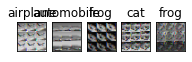

In [18]:
dataiter = iter(tr_loader)

images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(3,3))
# display 20 images
for idx in np.arange(5):
    ax = plt.subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].reshape(32,32,3))
    ax.set_title(classes[labels[idx]])

In [19]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    #input = 3 by 32 by 32
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 2, padding=0),
    #1nd layer_size = 8 by 15 by 15
        nn.ReLU(True),

        nn.Conv2d(in_channels =8, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
    #2nd leyar_size = 16 by 7 by 7   
        nn.ReLU(True),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2, padding = 0),
    #3nd layer_size = 32 by 3 by 3
        nn.ReLU(True),
    #   nn.Flatten(),
    #5nd layer (32, 32, 3, 3) -> (32, 32*3*3) 
    #   nn.Linear(32*3*3,10),
    #6nd layer (32, 32*3*3) -> (32, 10)
    #   nn.ReLU(True))
    )
    self.decoder = nn.Sequential(
    #   nn.Linear(10, 32*3*3),
    #    nn.ReLU(True),
    #1nd layer (32,10) -> (32,32*3*3)
    #    nn.Unflatten(1,(32,3,3)),
    #2nd layer (32, 32*3*3) -> (32, 32, 3, 3)
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2, padding =0),
        nn.ReLU(True),
    #3nd layer (batch_size, 16, 7, 7)
        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 0),
        nn.ReLU(True),
    #4nd layer (batch_size, 8, 15, 15)
        nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3, stride = 2, padding = 0, output_padding = 1),
    #5nd layer(batch_size, 3, 32, 32)
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [20]:
#Instantiate the model
model = DenosingAutoencoder()
print(model)

DenosingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [21]:
#Epochs
n_epochs = 50

#Optimizer
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay  = 1e-04)

#Onelr = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.005, epochs=n_epochs,
#                                            steps_per_epoch=len(tr_loader),cycle_momentum = True, base_momentum = 0.85, max_momentum = 0.95 )
# lr 0.1에서 1이 최적. 
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


DenosingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [23]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

Epoch : [1/50] 

0.001
Epoch : [2/50] 

0.001
Epoch : [3/50] 

0.001
Epoch : [4/50] 

0.001
Training Loss: 0.014415	 validation Loss 0.014699
Class:dog 	 PNSR :19.619937511582258 	 SSIM : 0.6557769974346942
Class:automobile 	 PNSR :14.323623559347105 	 SSIM : 0.6930495268561403
Class:horse 	 PNSR :19.25971416069595 	 SSIM : 0.7922273303184969
Class:cat 	 PNSR :12.126341920010905 	 SSIM : 0.8569346578515254
Class:dog 	 PNSR :24.138332357636344 	 SSIM : 0.8694291753627711


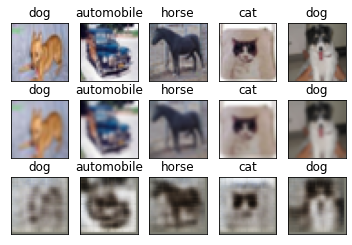

Epoch : [5/50] 

0.001
Epoch : [6/50] 

0.001
Epoch : [7/50] 

0.001
Epoch : [8/50] 



KeyboardInterrupt: ignored

In [24]:

train_loss_graph = np.array([])
val_loss_graph = np.array([])

start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model.train()
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_los = 0.0
    total_val_loss = 0.0
    tr_loader_iter = iter(tr_loader)
    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''

    #Training
    for i, (hat_input) in enumerate(hat_tr_dataloader):
        
        images, _ = tr_loader_iter.next()
        hat_images, _ = hat_input
        images = images.to(device)
 #check       print(images.shape)
        hat_images = hat_images.to(device)        
        optimizer.zero_grad()
 
#check0. print(hat_images.shape)  -> torch.Size([32, 3, 32, 32])

        outputs = model(hat_images)
#check      print(outputs.shape)
        loss = mse_loss(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        total_train_loss += train_loss
#        Onelr.step()
    print(get_lr(optimizer))
#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_loader)
    train_loss_graph = np.append(train_loss_graph, total_train_loss)


    #evaluation
    if (epoch+1)%5 == 0:

        model.eval()

        with torch.no_grad():   
          optimizer.zero_grad()
            
          val_loader_iter = iter(val_loader)
          hat_val_iter    = iter(hat_val_dataloader)



          for i in range(len(val_loader)):
              """
              enumerate는 메모리 누설로 batch를 잃어버리는 현상 발생
              """

         
              images, labels = val_loader_iter.next()
              hat_images,_ = hat_val_iter.next()

              images = images.to(device)
              hat_images = hat_images.to(device)
              outputs = model(hat_images)

              val_loss = mse_loss(outputs, images)
              val_loss = val_loss.item()
              total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
          total_val_loss = total_val_loss/len(val_loader)
          val_loss_graph = np.append(val_loss_graph, total_val_loss)
          print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     

          for j in range(5):
            val_ssim = ssim(images[j].cpu().detach().numpy().transpose(1, 2, 0), outputs[j].cpu().detach().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(images[j], outputs[j], max_val = 1.0)
            print(f'Class:{classes[labels[j]]} \t PNSR :{val_psnr} \t SSIM : {val_ssim}')
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(images[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])

            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_images[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])

            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])
          plt.show()   

end = time.time()
total_time = (end-start)/60
print(total_time,'m','\n')

In [ ]:
print(images[0].cpu().detach().numpy().transpose(1,2,0).shape)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_graph,'r-*')
plt.plot(val_loss_graph, 'b-*')
plt.legend(['train_loss_graph','val_loss_graph'])
plt.title("CIFAR10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()



In [ ]:
len(tr_loader)

In [ ]:
print(images.size(0))

In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()




In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
images = images.to(device)
print('입력 이미지 크기',images.shape)

output = model(images)
print('출력 이미지 크기',output.shape)

images_np = images.cpu().numpy() #입력값은 그래디언 계산이 안 되었으므로(model 안 거침) detach가 필요 없다.
output=output.to(device)
output_np = output.detach().cpu().numpy()

#Original Image(5):
for idx in np.arange(5):
    
    image, label = dataier.next()
    image = image.to(device)
    output = model()

    val_ssim_scikit =  ssim((images_np[idx], output_np[idx], data_range = 1.0,multichannel = True)           

    PSNR_custom = Get_psnr(images[idx], output[idx], max_val = 1.0)
    PSNR_scikit = psnr(images_np[idx], output_np[idx], data_range = 1.0)
#    SSIM = pytorch_ssim(images[idx],output[idx]).data
#    SSIM = ssim(images[idx], output[idx], data_range = 1.0, multichannel =True)
    print(f'Class {classes[labels[idx]]} Scikit_PSNR {PSNR_scikit} / Custom_PSNR {PSNR_custom}')
#   print(SSIM)
    print("SSIM : {.3f}", val_ssim_scikit)
    ax = plt.subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(classes[labels[idx]])

    ax = plt.subplot(2, 5, idx+1+5, xticks=[], yticks=[])
    imshow(output[idx].detach().cpu().numpy())
    ax.set_title(classes[labels[idx]])
plt.show() 